In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
from tqdm.notebook import tqdm

import cv2
## augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim

import numpy as np, pandas as pd, gc
import cv2, matplotlib.pyplot as plt

# ## Rapid
# import cudf, cuml, cupy
# from cuml.feature_extraction.text import TfidfVectorizer
# from cuml.neighbors import NearestNeighbors


import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# print('RAPIDS',cuml.__version__)
print('TF',tf.__version__)

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TF 2.4.1


## Dataset Visualization

In [2]:
train = pd.read_csv('../input/shopee-product-matching/train.csv')
train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [3]:
len(train), len(train.image.unique()), len(train.image_phash.unique())

(34250, 32412, 28735)

In [4]:
def plt_image(path):
    img = cv2.imread(path)
    plt.axis('off')
    plt.imshow(img[:,:,:])
    h,w = img.shape[:2]
    plt.title(f'{w} x {h}')

0: Paper Bag Victoria Secret
1: Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE
2: Maling TTS Canned Pork Luncheon Meat 397 gr
3: Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
4: Nescafe \xc3\x89clair Latte 220ml
5: CELANA WANITA  (BB 45-84 KG)Harem wanita (bisa cod)
6: Jubah anak size 1-12 thn
7: KULOT PLISKET SALUR /CANDY PLISKET /WISH KULOT PREMIUM /KULOT PELANGI PREMIUM/HIEKA KULOT
8: [LOGU] Tempelan kulkas magnet angka, tempelan angka magnet
9: BIG SALE SEPATU PANTOFEL KULIT KEREN KERJA KANTOR LAKI PRIA COWOK DINAS RESMI FORMAL PESTA KICKERS
10: Atasan Rajut Wanita LISDIA SWEATER
11: PASHMINA KUSUT RAWIS POLOS CRINKLE SHAWL MURAH BANGET
12: PASHMINA KUSUT RAWIS POLOS CRINKLE SHAWL MURAH BANGET PART 2
13: Lampu led t5 Speedometer Dashboard Motor Mobil 5050 Speedo Bright
14: Charger VIZZ VZ-TC11 / batok charger vizz 1A ORIGINAL REAL KAPASITAS
15: Korek Kuping LED untuk balita CherryBabyKidsShop SP LC


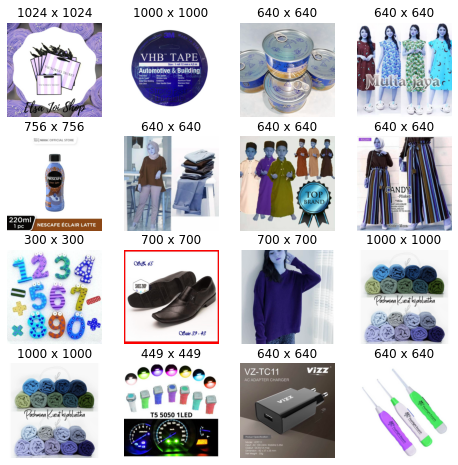

In [5]:
## Example of dataset image
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    img_path = train.image[i]
    img_path = "../input/shopee-product-matching/train_images/" + img_path
    plt_image(img_path)
    print(f"{i}: {train.title[i]}" )

In [6]:
grp = train.groupby('label_group', as_index=True).agg(
    counts=("image",'count'), 
    images=("image", list),
    titles=("title", list)
)
grp = grp.sort_values('counts', ascending=False)
print("Total Group", len(grp['counts']))
grp.head()

Total Group 11014


,counts,images,titles
label_group,,,
1163569239,51,"[089060edc61ec626e6b4943cf18dd651.jpg, 0ad5228...","[SCARLETT SERUM - BEBAS PILIH, SCARLETT WHITEN..."
159351600,51,"[09165142230c0d600c02a66f62dbee5d.jpg, 0ff3d41...",[Ready Stock - Gluta Collagen Soap By Beauteto...
994676122,51,"[029b2053e294c26f4a86a871bcddda9c.jpg, 03f94cf...","[KARET KUCIR PREMIUM, 100Pcs Karet Ikat Rambut..."
3113678103,51,"[00f671f9cc25eb024d5e6efb1b578dfc.jpg, 0bd991e...",[832P - FLEXIBLE Sambungan Kran FLEXIBLE irit ...
3627744656,51,"[027478fc15b3caf7d9be5465ad7bdf5c.jpg, 06a30c1...",[IMPLORA CHEEK & LIPTINT - IMPLORA LIP TINT OR...


<AxesSubplot:ylabel='Frequency'>

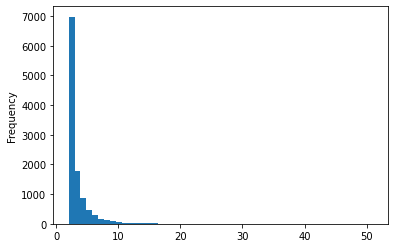

In [7]:
grp['counts'].plot.hist(bins=grp.counts.max())

0: Maskyourneeds All Varian (25gr - 65gr)
1: [DISTRIBUTOR] PO - MASKYOURNEEDS - MASKER 25gr&65gr | FREE SPATULA
2: Maskyourneeds 25gr
3: READY STOCK!! Masker Maskyourneeds 25gr
4: Maskyourneeds 25gr - 65gr
5: MASKYOURNEEDS
6: Maskyourneeds
7: MaskYourNeed (25gr & 65gr)
8: MASKYOURNEEDS MASKER ORGANIK [baca deskripsi]
9: READY MASKYOURNEEDS  [RESELLER RESMI]
10: READY TANPA PO Maskyourneeds 25 gr [RESELLER]
11: [RESELLER RESMI MASKYOURNEEDS] FREE GIFT
12: MASKYOURNEEDS Product  (25gr-65gr)
13: READY\xe2\x9d\xa4\xef\xb8\x8fMaskyourneeds 25gr - 65gr
14: (SOLD OUT) MASKYOURNEEDS 25gram
15: Maskyourneeds masker 65g {PO}


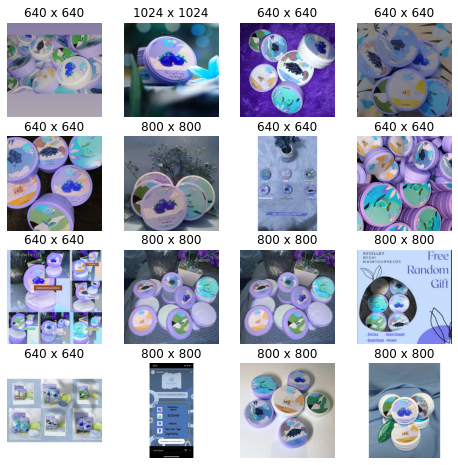

In [8]:
## Example of similar product
product_index = 27
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    img_path = grp.iloc[product_index].images[i]
    img_path = "../input/shopee-product-matching/train_images/" + img_path
    plt_image(img_path)
    print(f"{i}: {grp.iloc[product_index].titles[i]}" )

In [9]:
## Text data
train['title_length'] = train.title.map(lambda x: len(x.split()))

Max 61


<AxesSubplot:ylabel='Frequency'>

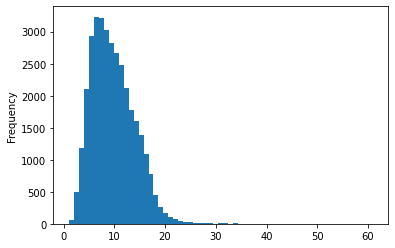

In [10]:
print("Max", train.title_length.max())
train.title_length.plot.hist(bins=train.title_length.max())

In [11]:
long_title = train.sort_values('title_length', ascending=False).title
for t in long_title[0:10]:
    print(t)

Silicone Case Premium Realme 7 7i 5i C15 C12 C17 C11 C2 C3 3 3i 5 6 C1 C3i 5 5S U1 X2 XT Q 6i 2 X2 5 PRO Narzo 20 PRO 10 10A 20A VIVO Y12 Y30 Y15 Y17 Y93 Y95 OPPO A31 2020 A9 A5 2020 A7 A5S A12 Cute Pearl Milk Tea Bear Soft Back Cover PopSocket
Soft Case Silikon Motif Kartun Beruang Warna Permen untuk OPPO A53 2020 Reno 4 A5S A5 2020 A3S A92 A31 A12 A9 2020 F9 PRO A37 A37F F1S F11 A1K F7 A52 A71 F5 Youth A7 A31 A33 2020 A91 Reno 2f Reno 3 A72 A12E Realme C15 C12 5i C11 C2 C3 3 3i 5 5S 6 C1 6i
Soft Case TPU Motif We Bare Bears Lucu dengan PopSocket untuk Realme 7 7i 5i C15 C12 C17 C11 C2 C3 3 3i 5 6 C1 C3i 5 5S U1 X2 XT Q 6i 2 X2 5 PRO Narzo 20 PRO 10 10A 20A VIVO Y12 Y30 Y15 Y17 Y93 Y95 OPPO A31 2020 A9 A5 2020 A7 A5S A12
Case Motif Kartun Beruang Lucu dengan Stand untuk OPPO A53 2020 Reno 4 A5S A5 2020 A3S A92 A31 A12 A9 2020 F9 PRO A37 A37F F1S F11 A1K F7 A52 A71 F5 Youth A7 A31 2020 A91 Reno 2f Reno 3 A72 A12E Realme C15 C12 5i C11 C2 C3 3 3i 5 5S 6 C1 6i Soft Case
Casing Soft Case 